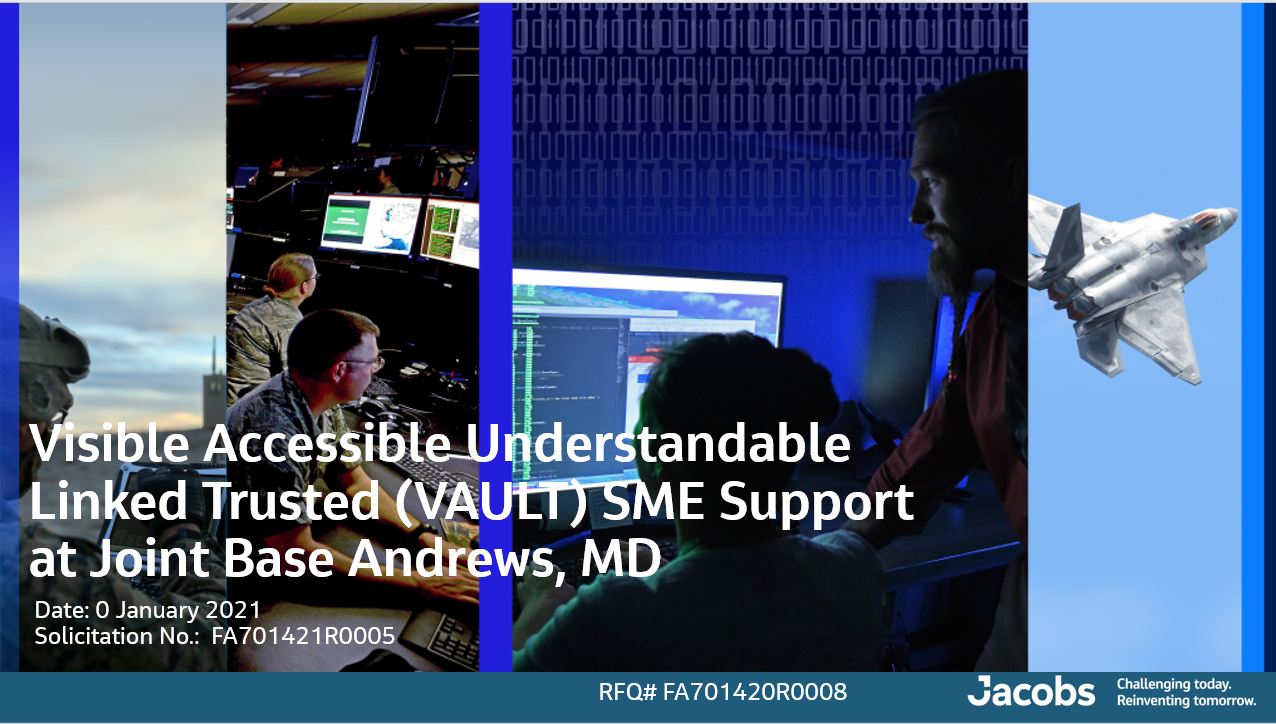

In [1]:
import sys

from vaultdemo import demo

from branca.colormap import linear
from datetime import datetime
from ipyleaflet import (Map, GeoData, basemaps, WidgetControl, GeoJSON,
 LayersControl, Icon, Marker,basemap_to_tiles, Choropleth,
 MarkerCluster, Heatmap,SearchControl, 
 FullScreenControl)
from ipywidgets import Text, HTML
from shapely.geometry import Point

import geopandas as gpd
import json
import math
import os
import pandas as pd
import fiona
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import plotly.express as px

# Data Received

We received ??? rows in ??? files comprising ??? bytes as described in the Tech Scenario:
 - Satellite Orbit data
   - 15 Files in Two Line Element (TLE) format
   https://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/SSOP_Help/tle_def.html
     - Year range 2004 to 2017
 - AIS Ship position data
   - 9 Files in CSV format
     - Year range 2015 to 2017
   - 6 Files in GDB data export format
     - Year range 2009 to 2014

In addition we received one additional file that appears to be a registry of a subset of DoD AIS transponders
 - 1 File in CSV format
   - Year 2020


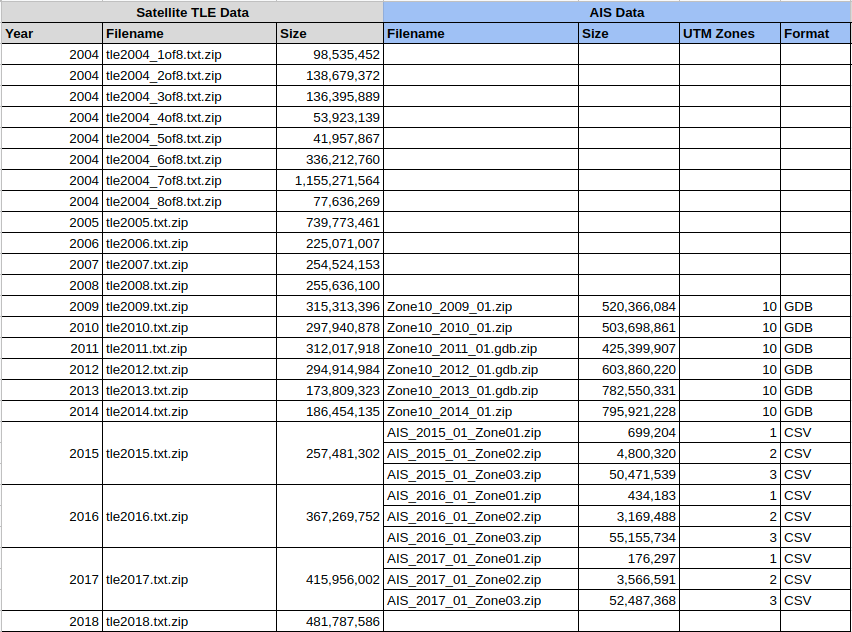

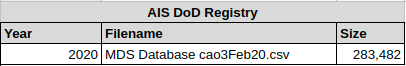

# Data Overview

In [2]:
def plot_daily(daily_counts_file, years):
    num_years = len(years)
    df = pd.read_csv(daily_counts_file,
        sep='\t',
        names=["date", "count"], 
        parse_dates=[0])
    for i in range(num_years):
        df_plot = df[(df['date']>datetime(years[i],1,1)) & (df['date']<datetime(years[i]+1,1,1))]
        fig = px.bar(df_plot, x="date", y="count", range_x=[datetime(years[i],1,1), datetime(years[i]+1,1,1)])
        fig.show()
#

## TLE Data

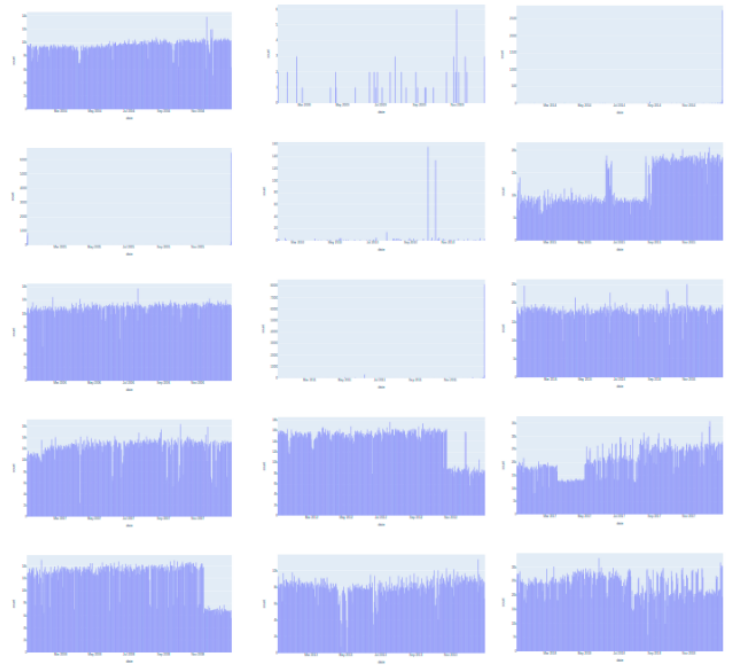

Distinct satellites: 18,817

Other Stats:

In [5]:
plot_daily("../data/VAULT_Data/stats_out/tle_daily_records.tab", list(range(2004,2019,1)))

## AIS Data

In [4]:
plot_daily("../data/VAULT_Data/stats_out/ais_daily_records.tab", list(range(2009,2018,1)))

Distinct Ships:  

Other stats:



# Data Strategy For Hit Test Algorithm

Because satellite orbital data is considered to be excellent quality so long as it is not more than 48 hours out of date, we chose to organize the TLE data on a per-day basis assigning one TLE line pair per day for every satellite.  This meant bringing older records forward when data was unavailable for a given day.

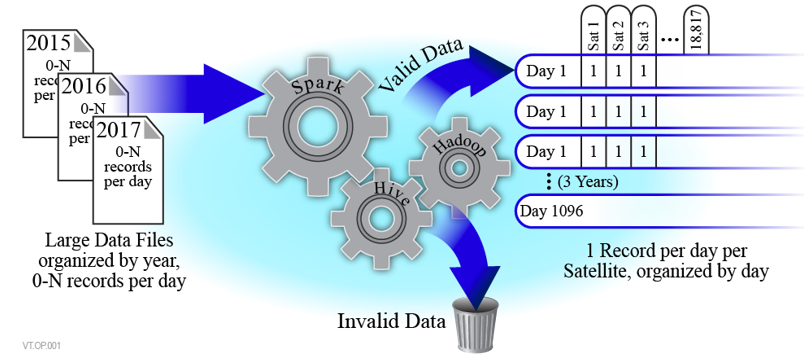

### Hit Test Algorithm Performance

With this approach we found we could compute all of the satellite positions for a given day in 6 seconds, unscaled.  Because the Spark resources available to this team take longer than 6 seconds to coordinate a task, we decided to leave this un-scaled.  This algorithm could be scaled easily over a microservices architecture, but not "two weeks easy" with our current resources.

### Hit Test Time Series View for Center of 2015-2017 Data

We did scale the algorithm as a whole to create the following investigative time-series using a Hive transform

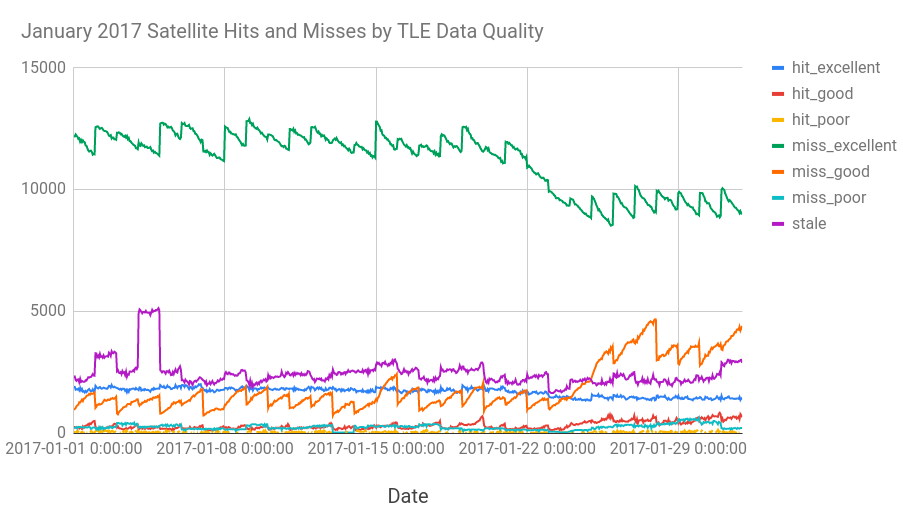

- Sawtooths are caused by a mixture of the choice of one satellite position per day and satellite positions being updated on average at slighly less than once every two day.
- The drift on the right side of the plot where miss_excellent decays in favor of hit_poor could be an indication that the poor data window we defined is a little too wide depending on the use case of the data.  If one is intent on avoiding detection, then the wider window would be the more cautious.  If one is intent on getting eyes on a target then a narrower window would be more appropriate.

# Enter Query Parameters

In [6]:
YEAR=2017
MMSI=366978710

In [7]:
demo = demo.Demo(YEAR, MMSI)

In [8]:
demo.show_map()

map

In [9]:
demo.map

Map(center=[53.90064321589477, -166.52488319885305], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [11]:
demo.hittest({"dt": "2017-01-31T05:16:05", "lat": 54.5261, "lon": -165.6512})

Trying to load ../data/VAULT_Data/TLE_daily/2017/01/31.tab.gz


0     1
           14345.0  2190
Excellent   1568.0  9607
Good         621.0  3683
Stale          NaN   858
Poor           NaN   196

In [12]:
demo.starmap()

### Satellite (Star) Map
 - View laying back and looking straight up
 - Instantaneous for time and location
    - Geosynchronous satellites remain fixed
    - Low Earth Orbit satellites may cross sky in 30 minutes or less

# Data Holes and Data Errors


A significant number of issues were identified in the given datasets
 - Data holes obvious in the first plotted figures
 - Per-entity gaps frequent (satellites, ships)
 - Multiple data quality issues
 - Data dictionary issues
 

## TLE Data Issues


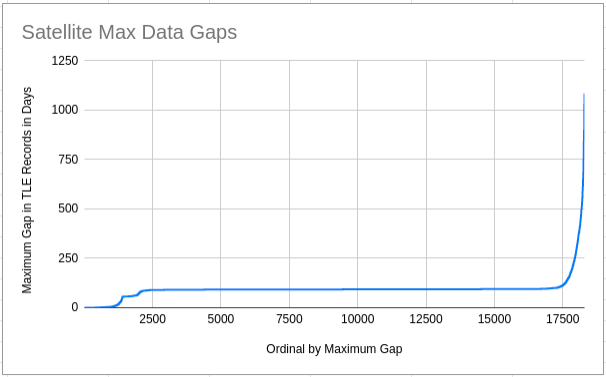

In [ ]:
pd.DataFrame({
    "Minumum Hole Size (in Days)": ["0", "<=1","<=2","<=14","<=28","<=56"],
    "Count": [425, 625, 809, 1217, 1325, 1522 ]
     })


So out of 18,817 satellites, very few had no holes in the provided data.

# Next

 - Microservice scale out of hit-algorithm
   - More responsive UI
 - Better map integration